In [1]:
import time
import random
from random import sample

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import cv2
import imageio
import matplotlib.pyplot as plt
import mahotas # haralick feature

In [3]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
def read_img(file_name):
    img_list,label_list = [],[]
    with open(file_name) as a:
        for i in a:
            img_list.append(i.strip()[:-2])
            label_list.append(int(i.strip()[-1]))
    
    return img_list,label_list

In [5]:
train_img_list,train_label = read_img("train.txt")
val_img_list,val_label = read_img("val.txt")
test_img_list,test_label = read_img("test.txt")

In [6]:
def get_feat(img_list,feat_extractor):
    winsize = (128,128)
    blocksize = (64,64)
    blockstride = (32,32)
    cellsize = (32,32)
    nbins = 9
    nlevels = 64
    hog = cv2.HOGDescriptor(winsize,blocksize,blockstride,cellsize,nbins,nlevels)

    img_feat_list = []
    for i in range(len(img_list)):
        if feat_extractor != "haralick":
            img = cv2.imread(img_list[i])
        else:
            img = cv2.imread(img_list[i],cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img,(128,128))

        if feat_extractor == "color histogram":
            img_feat = cv2.calcHist(img,[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
        elif feat_extractor == "hog":
            img_feat = hog.compute(img)
        elif feat_extractor == "haralick":
            img_feat = mahotas.features.haralick(img).mean(axis=0)
            
        img_feat = img_feat.reshape(-1)
        img_feat_list.append(img_feat)
    
    return img_feat_list

In [7]:
model_dict = {"AdaBoost":AdaBoostClassifier(),
              "XGBoost":XGBClassifier(),
              "LightGBM":LGBMClassifier()}

# Color Histogram

In [8]:
train_img_feat_list = get_feat(train_img_list,"color histogram")
val_img_feat_list = get_feat(val_img_list,"color histogram")
test_img_feat_list = get_feat(test_img_list,"color histogram")

In [9]:
epoch = 5
train_index = np.arange(len(train_img_feat_list))
for mod_name,mod in model_dict.items():
    train_time = []
    val_top1_list = []
    val_top5_list = []
    random.shuffle(train_index) # 對training set的index洗牌
    train_img_feat = np.array(train_img_feat_list)[train_index]
    label = np.array(train_label)[train_index]
    print("=== Start Training and Validating,Model:{} ===".format(mod_name))
    for i in range(epoch):
        # 紀錄訓練花費時間
        start_time = time.time()
        mod.fit(train_img_feat_list,label)
        end_time = time.time()
        train_time.append(end_time-start_time)

        # 紀錄validation的top1,top5
        pred_proba_val = mod.predict_proba(val_img_feat_list)
        val_top1 = (pred_proba_val.argmax(1) == val_label).sum()/len(val_label)
        val_top1_list.append(val_top1)
        val_top5_correct = [i for i in range(len(val_label)) if val_label[i] in np.argsort(-pred_proba_val,axis=1)[i,:5]]
        val_top5 = len(val_top5_correct)/len(val_label)
        val_top5_list.append(val_top5)

    # 紀錄testing的top1,top5
    pred_proba_test = mod.predict_proba(test_img_feat_list)
    test_top1 = (pred_proba_test.argmax(1) == test_label).sum()/len(test_label)
    test_top5_correct = [i for i in range(len(test_label)) if test_label[i] in np.argsort(-pred_proba_test,axis=1)[i,:5]]
    test_top5 = len(test_top5_correct)/len(test_label)

    train_time = np.array(train_time)
    val_top1_list = np.array(val_top1_list)

    print("Average training time:{},standard deviation:{}".format(np.mean(train_time),np.std(train_time)))
    print("Average Top1 Val Accuracy:{},standard deviation:{}".format(np.mean(val_top1_list),np.std(val_top1_list)))
    print("Average Top5 Val Accuracy:{},standard deviation:{}".format(np.mean(val_top5_list),np.std(val_top5_list)))
    print("Top1 Test Accuracy:{}".format(test_top1))
    print("Top5 Test Accuracy:{}".format(test_top5))

=== Start Training and Validating,Model:AdaBoost ===
Average training time:28.004565048217774,standard deviation:0.03519622974786314
Average Top1 Val Accuracy:0.10222222222222224,standard deviation:1.3877787807814457e-17
Average Top5 Val Accuracy:0.47777777777777775,standard deviation:5.551115123125783e-17
Top1 Test Accuracy:0.10888888888888888
Top5 Test Accuracy:0.4955555555555556
=== Start Training and Validating,Model:XGBoost ===
Average training time:115.49041318893433,standard deviation:0.14407144834137592
Average Top1 Val Accuracy:0.09111111111111111,standard deviation:0.0
Average Top5 Val Accuracy:0.4622222222222222,standard deviation:0.0
Top1 Test Accuracy:0.09777777777777778
Top5 Test Accuracy:0.5333333333333333
=== Start Training and Validating,Model:LightGBM ===
Average training time:3.2481056690216064,standard deviation:0.10744864431700499
Average Top1 Val Accuracy:0.08222222222222222,standard deviation:0.0
Average Top5 Val Accuracy:0.5,standard deviation:0.0
Top1 Test Accu

# HoG

In [10]:
train_img_feat_list = get_feat(train_img_list,"hog")
val_img_feat_list = get_feat(val_img_list,"hog")
test_img_feat_list = get_feat(test_img_list,"hog")

In [11]:
epoch = 5
train_index = np.arange(len(train_img_feat_list))
for mod_name,mod in model_dict.items():
    train_time = []
    val_top1_list = []
    val_top5_list = []
    random.shuffle(train_index) # 對training set的index洗牌
    train_img_feat = np.array(train_img_feat_list)[train_index]
    label = np.array(train_label)[train_index]
    print("=== Start Training and Validating,Model:{} ===".format(mod_name))
    for i in range(epoch):
        # 紀錄訓練花費時間
        start_time = time.time()
        mod.fit(train_img_feat_list,label)
        end_time = time.time()
        train_time.append(end_time-start_time)

        # 紀錄validation的top1,top5
        pred_proba_val = mod.predict_proba(val_img_feat_list)
        val_top1 = (pred_proba_val.argmax(1) == val_label).sum()/len(val_label)
        val_top1_list.append(val_top1)
        val_top5_correct = [i for i in range(len(val_label)) if val_label[i] in np.argsort(-pred_proba_val,axis=1)[i,:5]]
        val_top5 = len(val_top5_correct)/len(val_label)
        val_top5_list.append(val_top5)

    # 紀錄testing的top1,top5
    pred_proba_test = mod.predict_proba(test_img_feat_list)
    test_top1 = (pred_proba_test.argmax(1) == test_label).sum()/len(test_label)
    test_top5_correct = [i for i in range(len(test_label)) if test_label[i] in np.argsort(-pred_proba_test,axis=1)[i,:5]]
    test_top5 = len(test_top5_correct)/len(test_label)

    train_time = np.array(train_time)
    val_top1_list = np.array(val_top1_list)

    print("Average training time:{},standard deviation:{}".format(np.mean(train_time),np.std(train_time)))
    print("Average Top1 Val Accuracy:{},standard deviation:{}".format(np.mean(val_top1_list),np.std(val_top1_list)))
    print("Average Top5 Val Accuracy:{},standard deviation:{}".format(np.mean(val_top5_list),np.std(val_top5_list)))
    print("Top1 Test Accuracy:{}".format(test_top1))
    print("Top5 Test Accuracy:{}".format(test_top5))

=== Start Training and Validating,Model:AdaBoost ===
Average training time:150.75639543533325,standard deviation:1.764389823340131
Average Top1 Val Accuracy:0.11333333333333333,standard deviation:0.0
Average Top5 Val Accuracy:0.52,standard deviation:0.0
Top1 Test Accuracy:0.08
Top5 Test Accuracy:0.4666666666666667
=== Start Training and Validating,Model:XGBoost ===
Average training time:546.1518610477448,standard deviation:1.074931061191041
Average Top1 Val Accuracy:0.10888888888888888,standard deviation:0.0
Average Top5 Val Accuracy:0.49111111111111116,standard deviation:5.551115123125783e-17
Top1 Test Accuracy:0.11333333333333333
Top5 Test Accuracy:0.4911111111111111
=== Start Training and Validating,Model:LightGBM ===
Average training time:19.514385843276976,standard deviation:0.041861199295665945
Average Top1 Val Accuracy:0.11333333333333333,standard deviation:0.0
Average Top5 Val Accuracy:0.49111111111111116,standard deviation:5.551115123125783e-17
Top1 Test Accuracy:0.10444444444

# Haralick

In [12]:
train_img_feat_list = get_feat(train_img_list,"haralick")
val_img_feat_list = get_feat(val_img_list,"haralick")
test_img_feat_list = get_feat(test_img_list,"haralick")

In [13]:
epoch = 5
train_index = np.arange(len(train_img_feat_list))
for mod_name,mod in model_dict.items():
    train_time = []
    val_top1_list = []
    val_top5_list = []
    random.shuffle(train_index) # 對training set的index洗牌
    train_img_feat = np.array(train_img_feat_list)[train_index]
    label = np.array(train_label)[train_index]
    print("=== Start Training and Validating,Model:{} ===".format(mod_name))
    for i in range(epoch):
        # 紀錄訓練花費時間
        start_time = time.time()
        mod.fit(train_img_feat_list,label)
        end_time = time.time()
        train_time.append(end_time-start_time)

        # 紀錄validation的top1,top5
        pred_proba_val = mod.predict_proba(val_img_feat_list)
        val_top1 = (pred_proba_val.argmax(1) == val_label).sum()/len(val_label)
        val_top1_list.append(val_top1)
        val_top5_correct = [i for i in range(len(val_label)) if val_label[i] in np.argsort(-pred_proba_val,axis=1)[i,:5]]
        val_top5 = len(val_top5_correct)/len(val_label)
        val_top5_list.append(val_top5)

    # 紀錄testing的top1,top5
    pred_proba_test = mod.predict_proba(test_img_feat_list)
    test_top1 = (pred_proba_test.argmax(1) == test_label).sum()/len(test_label)
    test_top5_correct = [i for i in range(len(test_label)) if test_label[i] in np.argsort(-pred_proba_test,axis=1)[i,:5]]
    test_top5 = len(test_top5_correct)/len(test_label)

    train_time = np.array(train_time)
    val_top1_list = np.array(val_top1_list)

    print("Average training time:{},standard deviation:{}".format(np.mean(train_time),np.std(train_time)))
    print("Average Top1 Val Accuracy:{},standard deviation:{}".format(np.mean(val_top1_list),np.std(val_top1_list)))
    print("Average Top5 Val Accuracy:{},standard deviation:{}".format(np.mean(val_top5_list),np.std(val_top5_list)))
    print("Top1 Test Accuracy:{}".format(test_top1))
    print("Top5 Test Accuracy:{}".format(test_top5))

=== Start Training and Validating,Model:AdaBoost ===
Average training time:7.081859540939331,standard deviation:0.006099152576512504
Average Top1 Val Accuracy:0.07777777777777778,standard deviation:0.0
Average Top5 Val Accuracy:0.5266666666666666,standard deviation:0.0
Top1 Test Accuracy:0.10666666666666667
Top5 Test Accuracy:0.52
=== Start Training and Validating,Model:XGBoost ===
Average training time:36.47121963500977,standard deviation:0.046657979050502056
Average Top1 Val Accuracy:0.09555555555555556,standard deviation:0.0
Average Top5 Val Accuracy:0.5511111111111111,standard deviation:0.0
Top1 Test Accuracy:0.09555555555555556
Top5 Test Accuracy:0.4866666666666667
=== Start Training and Validating,Model:LightGBM ===
Average training time:1.0978629112243652,standard deviation:0.03212171481007602
Average Top1 Val Accuracy:0.09333333333333334,standard deviation:0.0
Average Top5 Val Accuracy:0.48,standard deviation:0.0
Top1 Test Accuracy:0.10222222222222223
Top5 Test Accuracy:0.49777

# CNN


In [14]:
import torch
import torchvision
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [79]:
def create_tensor(img_list,label,batchsize):
    feat_list = []
    for i in img_list:
        img = cv2.imread(i)
        img = cv2.resize(img,(128,128))
        img = np.transpose(img,(2,0,1))
        feat_list.append(img)
    feat_tensor = torch.tensor(np.array(feat_list),dtype=torch.float32)
    label_tensor = torch.tensor(np.array(label),dtype=torch.int64)
    dataset = TensorDataset(feat_tensor,label_tensor)
    dataloader = DataLoader(dataset,batch_size=batchsize,shuffle=True)
    return dataloader

In [80]:
train_loader = create_tensor(train_img_list,train_label,batchsize=64)
val_loader = create_tensor(val_img_list,val_label,batchsize=64)
test_loader = create_tensor(test_img_list,test_label,batchsize=64)

In [81]:
class mycnn(nn.Module):
    def __init__(self):
        super(mycnn,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5)
        self.cnn2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=5)
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.max2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(in_features=32*29*29,out_features=64)
        self.lin2 = nn.Linear(in_features=64,out_features=10)
        
    def forward(self,x):
        x = F.relu(self.cnn1(x))
        x = self.max1(x)
        x = F.relu(self.cnn2(x))
        x = self.max2(x)
        x = self.flatten(x)
        x = self.lin1(x)
        x = self.lin2(x)

        return(x)

In [82]:
mycnn()

mycnn(
  (cnn1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (cnn2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=26912, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=10, bias=True)
)

In [83]:
epochs = 10
mod = mycnn().to("cuda")
optimizer = torch.optim.Adam(mod.parameters(),lr=0.005)
loss_fn = nn.CrossEntropyLoss()

In [84]:
total_train_step = 0
total_val_step = 0
best_acc_loss = 100
train_acc_epoch, train_loss_epoch = [],[]
val_acc_epoch, val_loss_epoch = [],[]
train_acc_epoch_top5, val_acc_epoch_top5 = [],[]
for epoch in range(epochs):
    # training
    total_train_acc = 0
    total_train_acc_top5 = 0
    total_train_loss = 0
    for data in train_loader:
        imgs,targets = data
        imgs = imgs.to("cuda")
        targets = targets.to("cuda")

        optimizer.zero_grad()
        output = mod(imgs)
        loss = loss_fn(output,targets)
        total_train_loss += loss.item()
        accuracy = (output.argmax(1) == targets).sum() # top1 accuracy
        total_train_acc += accuracy.item()
        accuracy_top5 = len([i for i in range(len(targets)) if targets[i] in output.topk(5)[1][i]])
        total_train_acc_top5 += accuracy_top5
        loss.backward()
        optimizer.step()

        total_train_step += 1
        if total_train_step % 100 == 0:
            print("Times of training:{}, Training Loss:{}".format(total_train_step,loss))
    train_acc_epoch.append(total_train_acc/len(train_loader.dataset))
    train_acc_epoch_top5.append(total_train_acc_top5/len(train_loader.dataset))
    train_loss_epoch.append(total_train_loss/len(train_loader))
    # validation
    total_val_loss = 0
    total_val_acc = 0
    total_val_acc_top5 = 0
    with torch.no_grad():
        for data in val_loader:
            imgs,targets = data
            imgs = imgs.to("cuda")
            targets = targets.to("cuda")
            output = mod(imgs)
            loss = loss_fn(output,targets)
            total_val_loss += loss.item()
            val_acc = (output.argmax(1) == targets).sum()
            total_val_acc += val_acc.item()
            acc_top5 = len([i for i in range(len(targets)) if targets[i] in output.topk(5)[1][i]])
            total_val_acc_top5 += acc_top5
    val_acc_epoch.append(total_val_acc/len(val_loader.dataset))  
    val_acc_epoch_top5.append(total_val_acc_top5/len(val_loader.dataset))
    val_loss_epoch.append(total_val_loss/len(val_loader))

    if total_val_loss/len(val_loader) < best_acc_loss:
        best_acc_loss = total_val_loss/len(val_loader)
        weight = mod.state_dict()
    print("Validation loss:{}, Validation accuracy:{}".format(total_val_loss,total_val_acc/len(val_loader.dataset)))
    total_val_step += 1

    torch.save(weight,"hw1_best_mod.pth")

Times of training:100, Training Loss:2.2997307777404785
Times of training:200, Training Loss:2.3167154788970947
Times of training:300, Training Loss:2.3071913719177246
Times of training:400, Training Loss:2.2891669273376465
Times of training:500, Training Loss:2.3005218505859375
Times of training:600, Training Loss:2.298672676086426
Times of training:700, Training Loss:2.3049569129943848
Times of training:800, Training Loss:2.3101720809936523
Times of training:900, Training Loss:2.305828809738159
Validation loss:18.42843461036682, Validation accuracy:0.1
Times of training:1000, Training Loss:2.2935874462127686
Times of training:1100, Training Loss:2.3128883838653564
Times of training:1200, Training Loss:2.3031342029571533
Times of training:1300, Training Loss:2.301811456680298
Times of training:1400, Training Loss:2.3083391189575195
Times of training:1500, Training Loss:2.2962770462036133
Times of training:1600, Training Loss:2.2982325553894043
Times of training:1700, Training Loss:2.3

In [85]:
train_acc_epoch_top5

[0.506008685353336,
 0.50498223450454,
 0.5049664429530202,
 0.5026766679826293,
 0.5023924200552704,
 0.5057244374259771,
 0.5040189498618239,
 0.5061192262139755,
 0.5046190288195815,
 0.5014607185155942]

In [92]:
val_acc_epoch

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Text(0.5, 1.0, 'Validation loss per epoch')

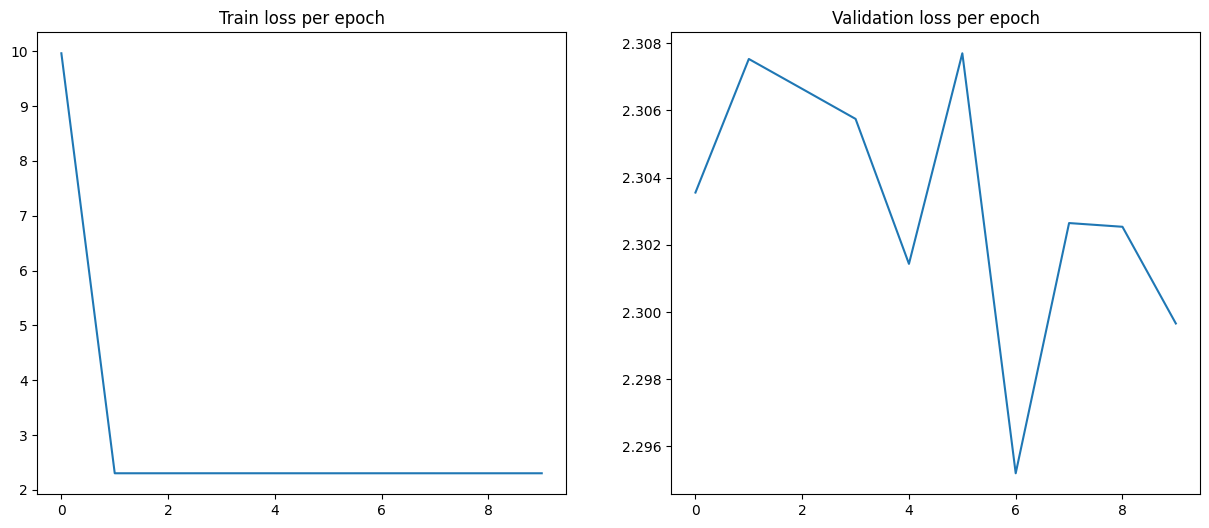

In [87]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(train_loss_epoch)
plt.title("Train loss per epoch")

plt.subplot(122)
plt.plot(val_loss_epoch)
plt.title("Validation loss per epoch")

Text(0.5, 1.0, 'Validation Top-1 accuracy per epoch')

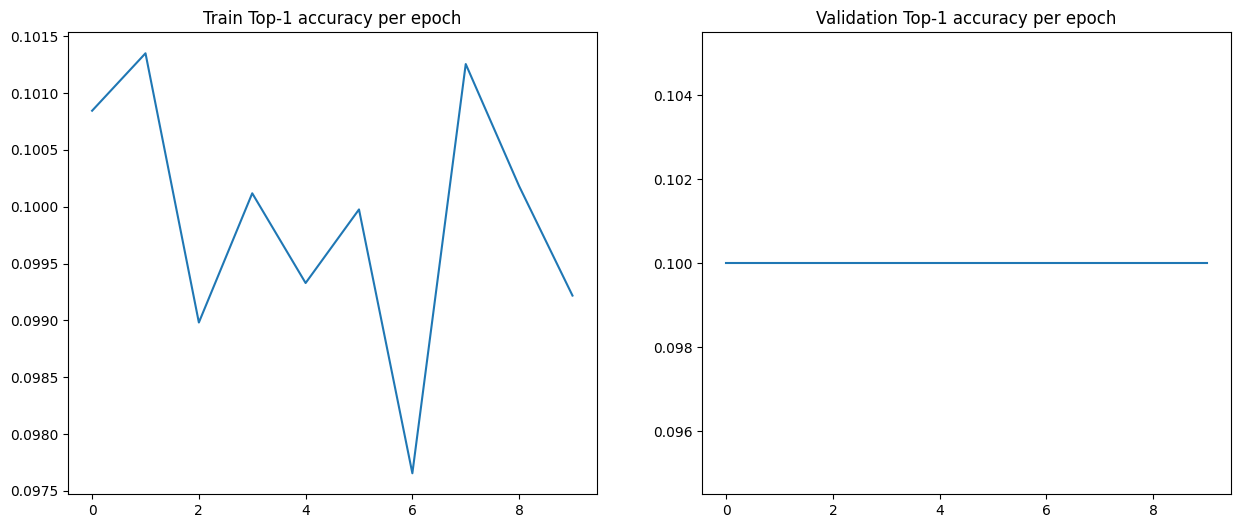

In [88]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(train_acc_epoch)
plt.title("Train Top-1 accuracy per epoch")

plt.subplot(122)
plt.plot(val_acc_epoch)
plt.title("Validation Top-1 accuracy per epoch")

Text(0.5, 1.0, 'Validation Top-5 accuracy per epoch')

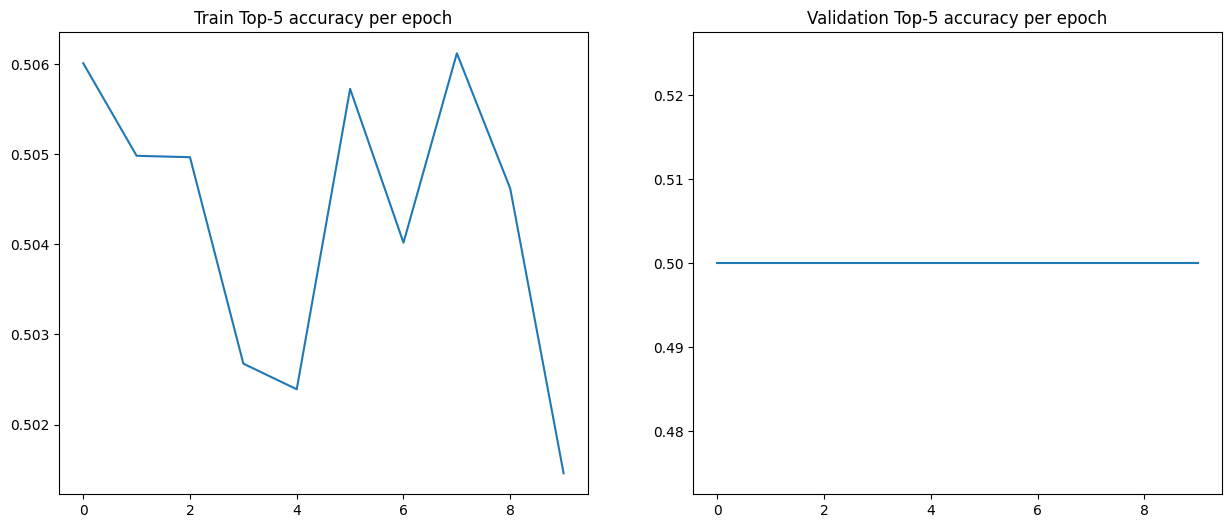

In [91]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(train_acc_epoch_top5)
plt.title("Train Top-5 accuracy per epoch")

plt.subplot(122)
plt.plot(val_acc_epoch_top5)
plt.title("Validation Top-5 accuracy per epoch")

In [90]:
mod = mycnn()
mod.load_state_dict(torch.load("hw1_best_mod.pth"))
mod = mod.to("cuda")
total_test_acc = 0
total_test_acc_top5 = 0
for data in test_loader:
    imgs,targets = data
    imgs = imgs.to("cuda")
    targets = targets.to("cuda")

    output = mod(imgs)
    test_correct = (output.argmax(1) == targets).sum()
    total_test_acc += test_correct
    acc_top5 = len([i for i in range(len(targets)) if targets[i] in output.topk(5)[1][i]])
    total_test_acc_top5 += acc_top5
print("Test top1 accuracy:{}".format(total_test_acc/len(test_loader.dataset)))
print("Test top5 accuracy:{}".format(total_test_acc_top5/len(test_loader.dataset)))

Test top1 accuracy:0.10000000149011612
Test top5 accuracy:0.5
